In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression,make_classification
from sklearn.linear_model import Ridge,LinearRegression,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import learning_curve,validation_curve,cross_validate


class ModelDiagnostics:

    def __init__(self,X,y,model,cv=5):
        self.X=X
        self.y=y
        self.model=model
        self.cv=cv
        self.diagnosis={}

    def commute_train_test_gap(self):
        cv_results=cross_validate(self.model,self.X,self.y,cv=self.cv,return_train_score=True,scoring='r2')
        train_score=cv_results['train_score'].mean()
        test_score=cv_results['test_score'].mean()
        gap=train_score-test_score

        self.diagnosis['train_score']=train_score
        self.diagnosis['test_score']=test_score
        self.diagnosis['gap']=gap

        return gap
    
    def check_learning_curve(self):

        train_sizes,train_scores,test_scores=learning_curve(
            self.model, self.X , self.y ,cv=self.cv , train_sizes=np.linspace(0.1,1,10),scoring='r2'#train sizes makes the training set 0.1 0.2 0.3 till 1
        )
    
        final_train=train_scores[-1].mean()
        final_test=test_scores[-1].mean()

        test_slope=(test_scores[-1].mean()-test_scores[-3].mean())/0.2
        

        self.diagnosis['converged']=abs(test_slope)<0.01
        self.diagnosis['test_slope']=test_slope

        return final_train,final_test,test_slope
        
    def diagnose(self):
        gap=self.commute_train_test_gap()
        train_score,test_score,slope=self.check_learning_curve()

        print("="*50)
        print(f"MODEL DIAGNOSIS: {self.model.__class__.__name__}")
        print("="*50)
        print(f"Train Score: {train_score:.4f}")
        print(f"Test Score:  {test_score:.4f}")
        print(f"Gap:         {gap:.4f}")
        print(f"Converged:   {self.diagnosis['converged']}")
        print()
        
        if test_score < 0.6 and gap < 0.1:
            verdict = "🔴 UNDERFITTING (High Bias)"
            suggestion = "→ Increase model complexity, add features, reduce regularization"
        elif gap > 0.15:
            verdict = "🔴 OVERFITTING (High Variance)"
            suggestion = "→ Add regularization, get more data, reduce model complexity"
        elif not self.diagnosis['converged'] and slope > 0.01:
            verdict = "🟡 NEEDS MORE DATA"
            suggestion = "→ Collect more training samples"
        else:
            verdict = "🟢 GOOD FIT"
            suggestion = "→ Model is performing well!"
        
        print(f"VERDICT: {verdict}")
        print(f"ACTION:  {suggestion}")
        print("="*50)
        print()
        
        return verdict        


🔍 DIAGNOSING 5 MODELS


Testing: 1. Linear (Too Simple)
MODEL DIAGNOSIS: Ridge
Train Score: 0.4644
Test Score:  0.4490
Gap:         0.0154
Converged:   False

VERDICT: 🔴 UNDERFITTING (High Bias)
ACTION:  → Increase model complexity, add features, reduce regularization


Testing: 2. Linear (Good)
MODEL DIAGNOSIS: Ridge
Train Score: 0.9947
Test Score:  0.9940
Gap:         0.0007
Converged:   True

VERDICT: 🟢 GOOD FIT
ACTION:  → Model is performing well!


Testing: 3. Polynomial Degree 5
MODEL DIAGNOSIS: Pipeline
Train Score: 1.0000
Test Score:  0.2330
Gap:         0.7670
Converged:   False

VERDICT: 🔴 OVERFITTING (High Variance)
ACTION:  → Add regularization, get more data, reduce model complexity


Testing: 4. Deep Tree (Overfit)
MODEL DIAGNOSIS: DecisionTreeRegressor
Train Score: 1.0000
Test Score:  0.3346
Gap:         0.6392
Converged:   False

VERDICT: 🔴 OVERFITTING (High Variance)
ACTION:  → Add regularization, get more data, reduce model complexity


Testing: 5. Shallow Tree
MODEL

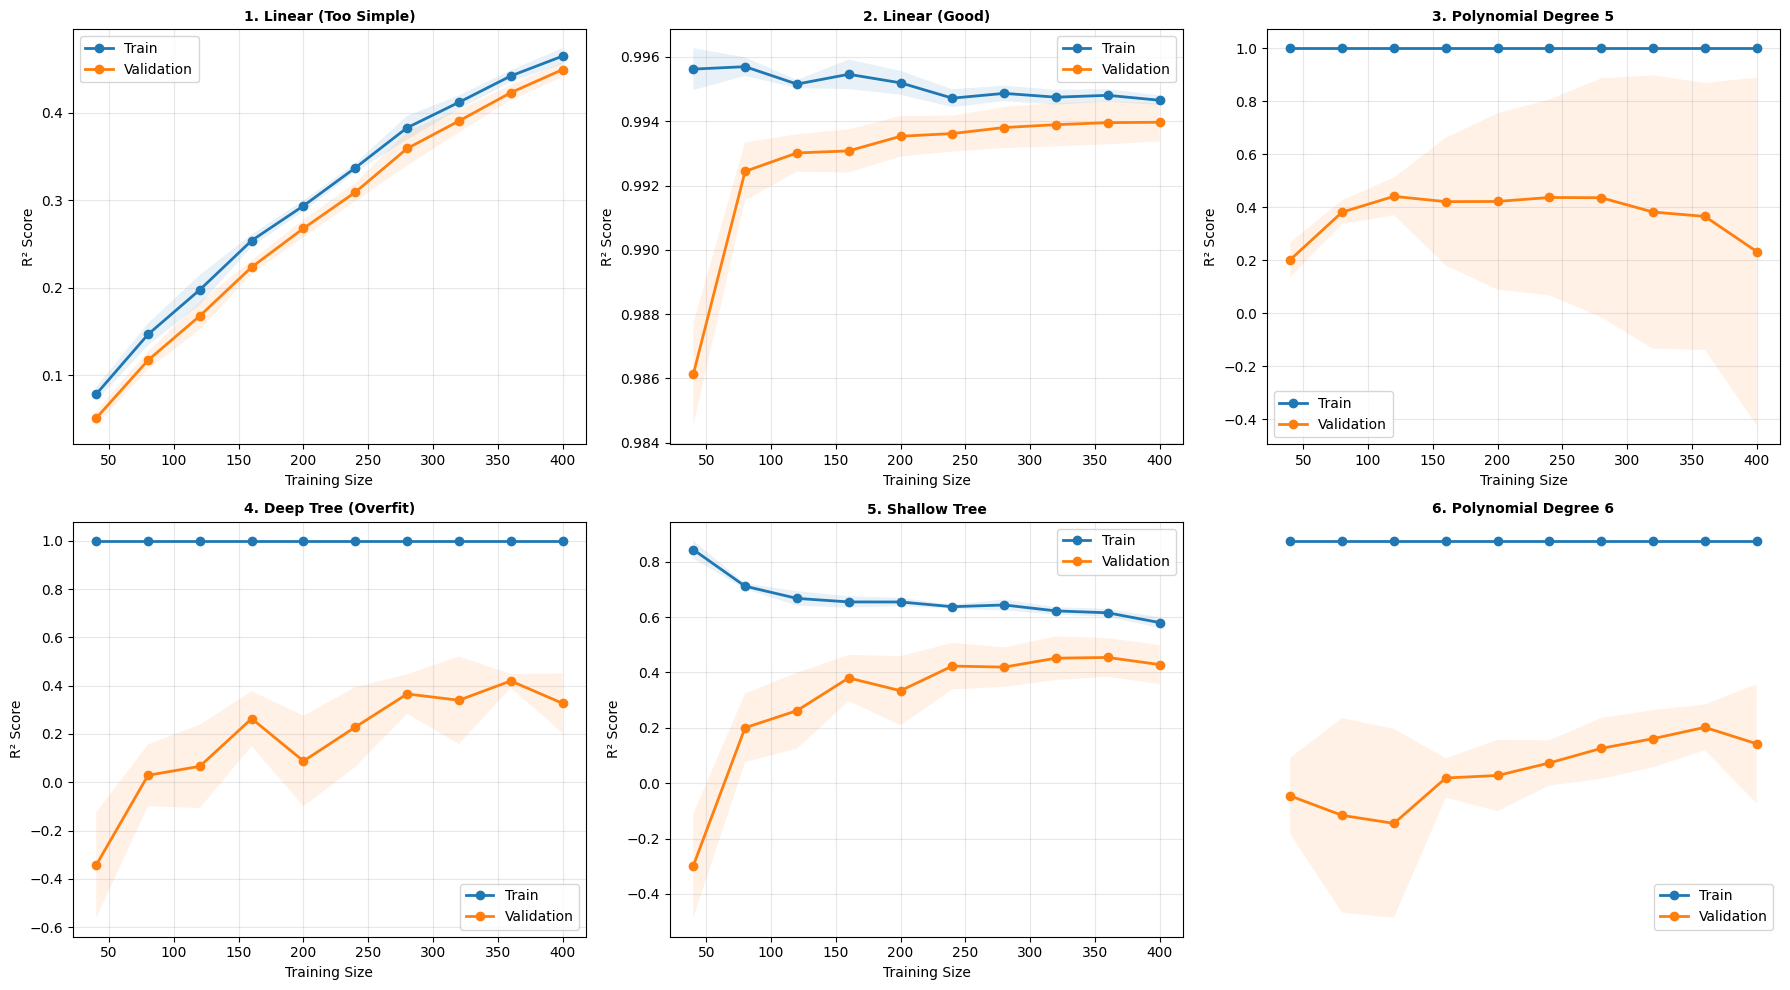

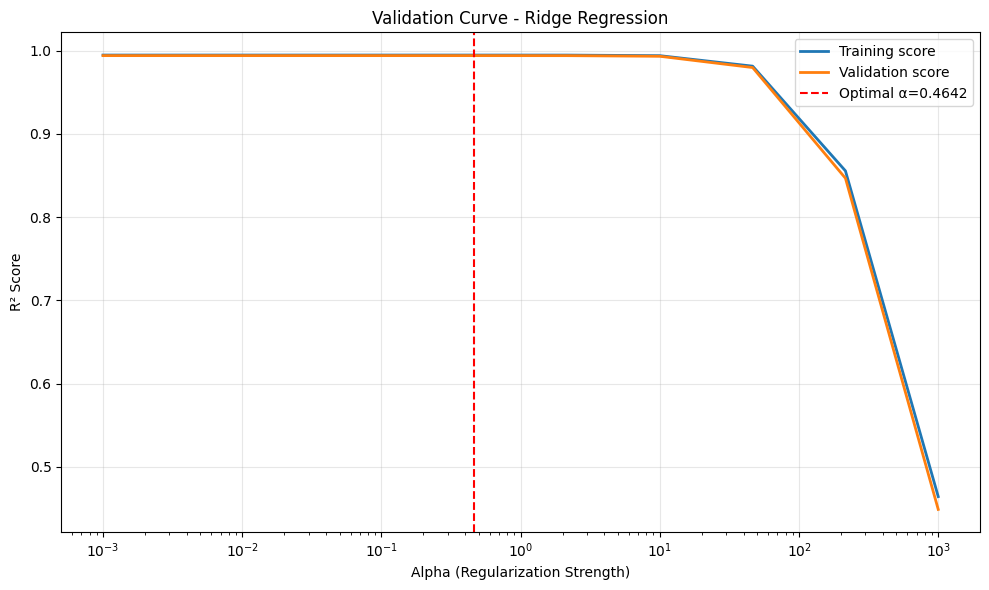

In [16]:

# TEST ON  DIFFERENT MODELS


# Generate regression data
np.random.seed(42)
X, y = make_regression(n_samples=500, n_features=20, n_informative=10, 
                       noise=10, random_state=42)

print("\n🔍 DIAGNOSING 5 MODELS\n")

models = [
    ("1. Linear (Too Simple)", Ridge(alpha=1000)),
    ("2. Linear (Good)", Ridge(alpha=1)),
    ("3. Polynomial Degree 5", make_pipeline(PolynomialFeatures(5), Ridge(alpha=0.1))),
    ("4. Deep Tree (Overfit)", DecisionTreeRegressor(max_depth=20)),
    ("5. Shallow Tree", DecisionTreeRegressor(max_depth=3)),
    ("6. Polynomial Degree 6", make_pipeline(PolynomialFeatures(6), Ridge(alpha=0.1))),

]

results = []
for name, model in models:
    print(f"\n{'='*50}")
    print(f"Testing: {name}")
    print('='*50)
    
    diagnoser = ModelDiagnostics(X, y, model, cv=5)
    verdict = diagnoser.diagnose()
    results.append((name, diagnoser.diagnosis))


# VISUALIZE ALL DIAGNOSTICS


fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, (name, model) in enumerate(models):
    # Learning curve
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10), scoring='r2'
    )
    
    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    test_std = test_scores.std(axis=1)
    
    axes[idx].plot(train_sizes, train_mean, 'o-', label='Train', linewidth=2)
    axes[idx].plot(train_sizes, test_mean, 'o-', label='Validation', linewidth=2)
    axes[idx].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    axes[idx].fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
    axes[idx].set_title(name, fontsize=10, fontweight='bold')
    axes[idx].set_xlabel('Training Size')
    axes[idx].set_ylabel('R² Score')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

# Hide extra subplot
axes[-1].axis('off')

plt.tight_layout()
plt.savefig('model_diagnostics.png', dpi=100, bbox_inches='tight')
print("\n✅ Saved visualization: model_diagnostics.png\n")

# VALIDATION CURVE - Find Optimal Hyperparameter


print("\n📊 VALIDATION CURVE: Finding Optimal Alpha")
print("="*50)

param_range = np.logspace(-3, 3, 10)
train_scores, test_scores = validation_curve(
    Ridge(), X, y, param_name="alpha", param_range=param_range,
    cv=5, scoring="r2"
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

best_alpha = param_range[np.argmax(test_mean)]
print(f"Optimal Alpha: {best_alpha:.4f}")
print(f"Best Test Score: {test_mean.max():.4f}")

plt.figure(figsize=(10, 6))
plt.semilogx(param_range, train_mean, label='Training score', linewidth=2)
plt.semilogx(param_range, test_mean, label='Validation score', linewidth=2)
plt.axvline(best_alpha, color='r', linestyle='--', label=f'Optimal α={best_alpha:.4f}')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('R² Score')
plt.title('Validation Curve - Ridge Regression')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('validation_curve.png', dpi=100, bbox_inches='tight')
print("✅ Saved: validation_curve.png\n")

# SUMMARY TABLE


print("\n📋 SUMMARY OF ALL MODELS")
print("="*80)
print(f"{'Model':<30} {'Train':<10} {'Test':<10} {'Gap':<10} {'Status'}")
print("="*80)

for name, diag in results:
    status = "✅ Good" if abs(diag['gap']) < 0.1 else "⚠️  Check"
    print(f"{name:<30} {diag['train_score']:>8.4f}  {diag['test_score']:>8.4f}  {diag['gap']:>8.4f}  {status}")

print("="*80)
print("\n🎯 Key Insights:")
print("• Gap > 0.15 → Overfitting (reduce complexity)")
print("• Test < 0.6 & Gap < 0.1 → Underfitting (increase complexity)")
print("• Converging curves → Good fit")
print("• Diverging curves → Variance issue")